In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.patches import Rectangle
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, ElasticNet, RidgeCV, Lasso
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.preprocessing.sequence import pad_sequences
warnings.resetwarnings()

## Baseline comparisons.

Because I am predicting the number of new cases per million on a daily basis, (i.e. not the rate) I am going to employ a naive (constant) baseline.


## Metric to determine model accuracy

I will be using mean absolute error as to minimize the effect of outliers.


## Details yet to be incorporated:

Growth of standard deviation over time in forecasting.
To accomplish this, I will produce a number of "new" features which attempt to capture the time dependence via rolling averages and rolling standard deviations. I will also one-hot encode certain variables which represent flags for certain behaviors or discrete, time independent variables such as location (country).

# Modeling the number of cases of COVID-19


# Table of contents<a id='toc'></a>

## [COVID-19 Case number modeling ](#model)


In [37]:

def country_search(df, country):
    return df[df.location==country].index

def country_groupby(df):
    return [df[df.location==country].index for country in df.location.unique()]


def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None



# Copied from last capstone project. 
def classifier_analysis(clf, X_test, y_test, plot=True, metric='evs'):
    
    '''
        Predict using trained scikit-learn estimator and compute and plot various metrics:
        Prints 
        
        Parameters:
        
        X_test : ndarray or DataFrame (n_samples, n_features)
                 Feature data to test. n_features represents the number of features
                 present in the data used to train the estimator clf
                 
        y_test : ndarray (n_samples, )
                 Target data to test. 
                
        
        clf : scikit-learn estimator which has been fit to data with same number of 
              columns as X_test
        
        
        Returns:
        
        y_test : ndarray (n_samples, )
            
            Same as input for convenience
        
        y_predict : ndarray (n_samples, ) 
            
            Predictions 
        
    '''
    
    y_predict = clf.predict(X_test)
    
    # Print the mean squared error and explained variance
    if metric == 'evs':
        score = explained_variance_score(y_test, y_predict)
    elif metric == 'mae':
        score = mean_absolute_error(y_test, y_predict)
    else:
        score = mean_squared_error(y_test, y_predict)

#     print('Mean squared error {}'.format(mse_))
#     print('Explained variance score {}'.format(evs_))
    
    if plot:
        # Plot true vs. predicted as scatter plot. 
        ym = np.max(y_test)
        fig = plt.figure()
        plt.scatter(y_test, y_predict, s=1)
        plt.plot([0, ym],[0, ym],color='r')
        plt.ylabel('Predicted Value')
        plt.xlabel('True Value')
        plt.grid()
        plt.xlim([0, 1.1*ym])
        plt.ylim([0, 1.1*ym])
        _ = plt.show()
    
    return y_test, y_predict, score

def true_predict_plot(y_true, y_naive, y_predict, title='', scale=None):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,5))
    
    if scale == 'log':
        ymax = np.max([np.log(1+y_true).max(), np.log(1+y_predict).max()])
        ax1.scatter(np.log(y_true+1), np.log(y_naive+1), s=5)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(np.log(y_true+1), np.log(y_predict+1), s=5)
        ax2.plot([0, ymax], [0, ymax],color='r')
    else:
        ymax = np.max([y_true.max(), y_predict.max()])
        ax1.scatter(y_true, y_naive, s=5)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(y_true, y_predict+1, s=5)
        ax2.plot([0, ymax], [0, ymax],color='r')
    ax1.set_xlabel('True value')
    ax1.set_ylabel('Predicted value')
    ax1.set_title('Naive model')

    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted value')
    ax2.set_title('Ridge regression model')
    ax1.grid(True)
    ax2.grid(True)
    plt.show()
    return None

def residual_plot(y_true,y_predict,title='', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_true, y_true-y_predict.ravel(), s=5)
    ax.set_ylabel('Residual')
    ax.set_xlabel('True value')
    ax.grid(True)
#     plt.show()
    return None

def residual_diff_plots(y_true, y_naive, y_predict,n_days_into_future, n_countries, scale=None):
    print(y_true.shape, y_naive.shape, y_predict.shape)
    fig, axes = plt.subplots(2, 2, figsize=(20,5), sharey=True)
    (ax1,ax2,ax3,ax4) = axes.flatten()
    xrange = range(len(y_true))
    if scale=='log':
        ax1.plot(xrange, np.log(y_true+1)
             -np.log(y_naive+1))
        ax2.plot(xrange, np.log(y_true+1)
                 -np.log(y_predict+1))
        residual_plot(np.log(y_true+1),np.log(y_naive+1), ax=ax3)
        residual_plot(np.log(y_true+1),np.log(y_predict+1), ax=ax4)
    else:
        ax1.plot(xrange, y_true-y_naive)
        ax2.plot(xrange, y_true-y_predict)
        residual_plot(y_true,y_naive, ax=ax3)
        residual_plot(y_true,y_predict, ax=ax4)
    fig.suptitle('{}-day-into-future predictions'.format(n_days_into_future))
    ax1.set_title('Country-wise differences')
    ax2.set_title('Country-wise differences')
    ax1.set_ylabel('log(|True - Naive|)')
    ax2.set_ylabel('log(|True - CNN|)')
    ax1.grid(True)
    ax2.grid(True)

    plt.show()

## Data

Data has the following partitions (list in order of partition as realized in data used in modelling):

    1. Continuous time dependent data
    2. Rolling averages of continuous time dependent data
    3. Continuous time independent data
    4. One-hot encoded data: location (country), flags for government responses, test units. 
    5. Time indexing variables (date, time-index (days since first case))
        
    Continuous time dependent data with drift as baseline model, Rolling averages computed afterwards
    Time series variables with naive as baseline model : The complement to the drift baseline variables. 

tried scaling y.
What do these values mean? The above values represent the maximum factor or magnitude which each country is trying to predict.
i.e. when normalized up to frame N, the new_cases_weighted max will be, of course, 1. A y_train_model value of 20 means that the future value is 20 times larger than the current in-frame max.

Weighting values up to frame n with max, min in all days up until then. Then, 

# data preprocessing

    get rid of all pre-global data, i.e. the days before every country in dataset has at least 1 case.
    this corresponds to truncation via time_index or days_since_first_case

# data format lists

    single day, single country for each prediction
    multiple day, single country for each prediction
    single day, multiple country for each prediction. 
   
# normalization methods
    
    none (wrong)
    entire train, test (wrong)
    up to present date minmax, standard scaler
    in-frame minmax, standard scalar
    up to present day and then in-frame. 
    


# the types of models used
     
     Ridge(alpha=0.01, fit_intercept=False)
     Lasso(alpha=0.01, fit_intercept=False)
     ElasticNet(alpha=0.01, l1_ratio=0.9, fit_intercept=False)

# Things tried so far

    Lasso, Ridge, ElasticNet and their parameters
    minmax and standard normal, normalization
    in-frame and historical normalization

I think I'm safe as long as the training data does not include any days included in the 14 day rolling average of the day that I am trying to predict.

In [38]:
def n_day_forecasting(data, n_test_days, n_days_into_future, col_transformer=StandardScaler(), n_prune=2, train_or_test='train'):
    # X has already been shifted by n_days_into future, so the last day in X is predicting that last day + n_days_into_future. 
    #     y_naive = X.new_cases_weighted[X.time_index > X.time_index.max() - n_days_into_future]
    n_countries = data.location.nunique()
    chronological_data = data.sort_values(by=['time_index','location'])
    # chronological_data = chronological_data[chronological_data.days_since_first_case >0].reset_index(drop=True)

    X = chronological_data[(chronological_data.time_index 
                            <=  chronological_data.time_index.max() - n_days_into_future)].reset_index(drop=True)
    y = chronological_data[(chronological_data.time_index  
                            >= n_days_into_future)].loc[:, ['time_index','new_cases_weighted']].reset_index(drop=True)

    train_indices = X[X.time_index <= X.time_index.max() - n_test_days].index
    test_indices = X[X.time_index > X.time_index.max() - n_test_days].index

    # 2 slices date, location, 4 slices date,location,time_index, days_since_first_case
    X_train = X.iloc[train_indices, n_prune:]#.apply(lambda x : np.log(x+1))
    y_train = y.loc[train_indices]

    X_test = X.iloc[test_indices, n_prune:]#.apply(lambda x : np.log(x+1))
    y_test =  y.loc[test_indices]

    _ = col_transformer.fit(X_train)
    X_train_normalized =  col_transformer.transform(X_train)
    X_test_normalized =  col_transformer.transform(X_test)

    n_step_models = []

    model = Ridge(alpha=0.01, fit_intercept=False, tol=1e-12) 
    _ = model.fit(X_train_normalized, y_train)
    
    if train_or_test == 'train':
        y_naive = X_train.new_cases_weighted
        y_true, y_predict, mae = classifier_analysis(model, X_train_normalized, y_train, plot=False, metric='mae')
    else:
        y_naive = X_test.new_cases_weighted
        y_true, y_predict, mae = classifier_analysis(model, X_test_normalized, y_test, plot=False, metric='mae')

        
    return  (X_train_normalized, X_test_normalized), (y_true, y_naive, y_predict), model 

to make the regression work, need to leverage the time dependence more, I'm going to elect to use multiple day values of the same country to predict the values for each country one at a time, because the differences between countries are so large (in terms of weighted quantities). 

To do so, need to repeat the data such that (7, 14) days of predictors are in each row for each prediction. I.e. each row
is a single country but their frame values. I just did this but perhaps it would be easier to create the frames from the CNN notebook?

Resetting the index makes it so X's index can be used to slice y. I.e. its the operation which "realigns" the data.

Things to try or have been tried.

Slicing the countries which have 0 mean for any variables as this is indicative of having no information. 

In [11]:
data = pd.read_csv('regression_data_optimal.csv', index_col=0)
# data[data.location=='United States'].new_cases_weighted.plot()

In [12]:
data[data.days_since_first_case > 0].groupby('location').time_index.min().max()

113

should likely slice countries which have not had sufficient amount of time of infection,
do not have recorded values, and time_index < ~40 

# Prediction without any normalization

In [49]:
data = pd.read_csv('regression_data_optimal.csv', index_col=0)

In [66]:
n_prune = 4
mae_list_naive = []
r2_list_naive = []
mae_list_predict = []
r2_list_predict = []
# data = data[data.time_index >= first_day]
model_data = data.iloc[:, n_prune:].copy()#.apply(lambda x : np.log(x+1))
new_cases_index = column_search(model_data,'new_cases_weighted',threshold='match', return_style='iloc')[0]
n_countries = data.location.nunique()
target_data = data.new_cases_weighted
time_index = data.time_index
frame_size = 14
start_date = frame_size + time_index.min()
# start_date = 50
n_validation_frames = 0
n_test_frames = 1
n_days_into_future = 1
train_or_test = 'train'

for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 2):
    # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
    frame_data = model_data[(time_index < max_date_in_window) & 
                            (time_index >= max_date_in_window-frame_size)]
    #     print(frame_data.shape)
    # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
    reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
    #     print(reshaped_frame_data.shape)
    # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
    # the first axis is always the default iteration axis. 
    # *********************** WARNING: pad_sequences converts to integers by default *********************
    resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
    frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
    if max_date_in_window == start_date:
        X = frame_data_4D.copy()
    else:
        X = np.concatenate((X, frame_data_4D),axis=0)

y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
y_time_index = time_index.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]

X_train= X[:-n_test_frames,:,:,:]
y_train =  y[:-n_test_frames,:]
X_test = X[-n_test_frames:, :, :, :] 
y_test = y[-n_test_frames:, :]
splits =  (X_train, y_train, X_test, y_test)
y_train_time = y_time_index[:-n_test_frames,:]
y_test_time = y_time_index[-n_test_frames:, :]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1309415.5431820462, tolerance: 3708.8955827227237
  positive)


There were 916 negative predictions
1-step MAE [Naive, Ridge Regression] = [3.4279637407069306,3.4695561288954897]
1-step R^2 [Naive, Ridge Regression] = [0.7461509998503622,0.9268186256132275]


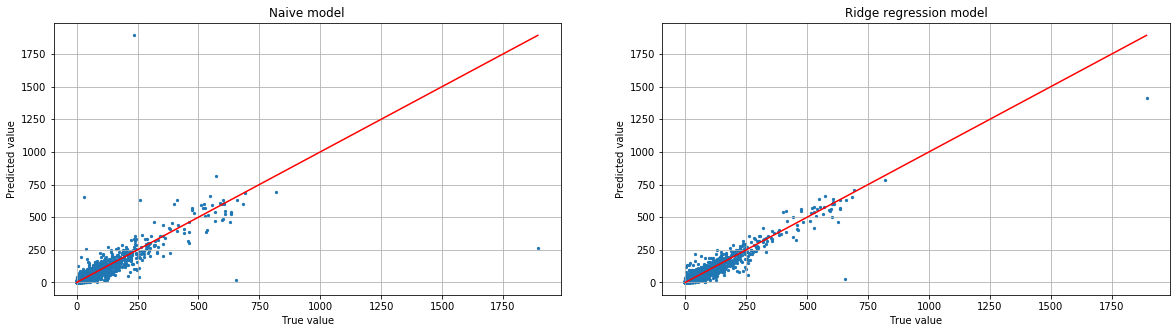

(18765,) (18765,) (18765,)


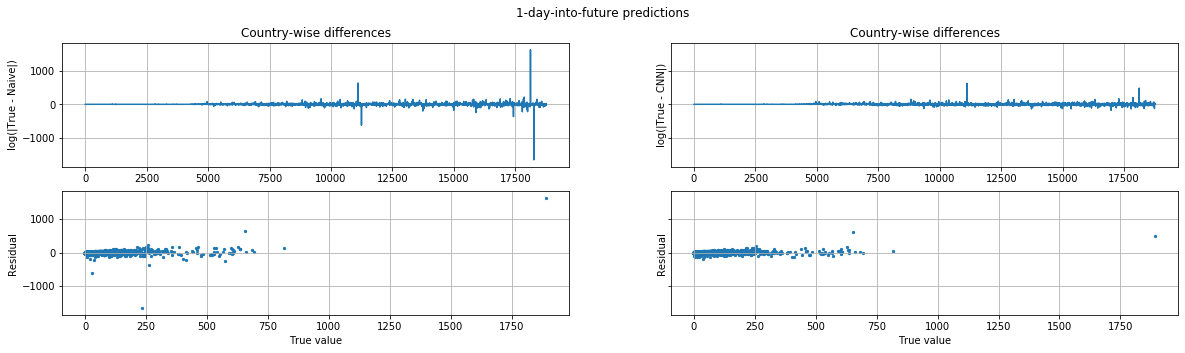

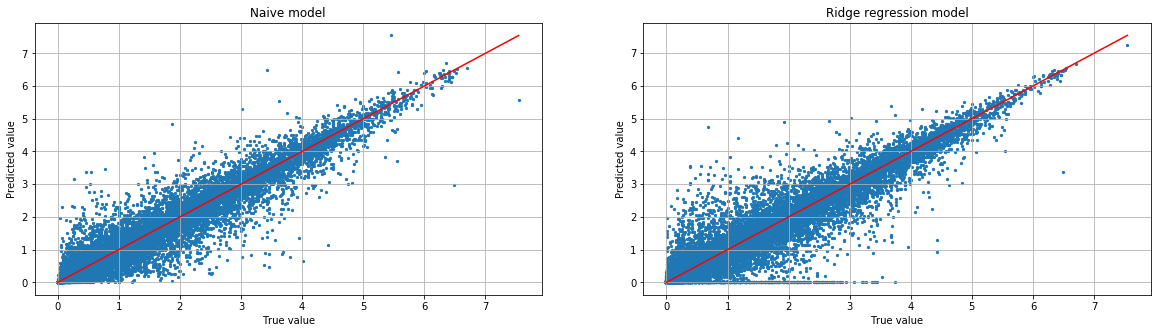

(18765,) (18765,) (18765,)


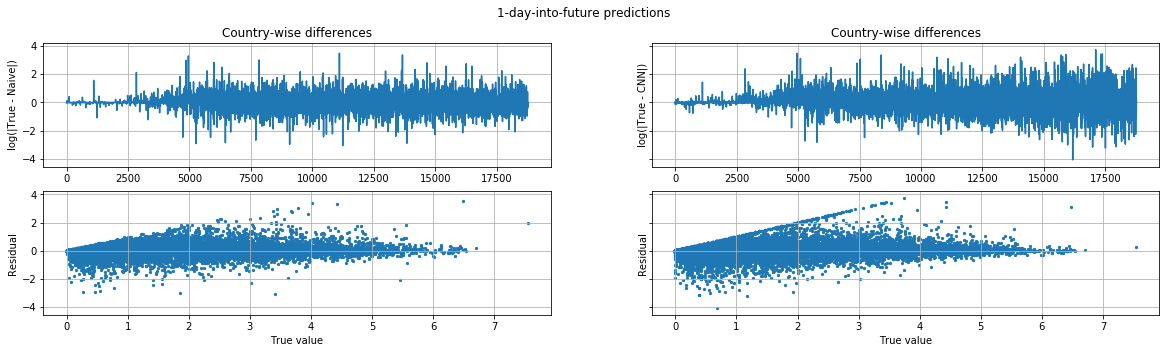

In [67]:
X_train_model = np.concatenate(X_train.reshape(X_train.shape[0], X_train.shape[1], -1), axis=0)
X_test_model = np.concatenate(X_test.reshape(X_test.shape[0], X_test.shape[1], -1), axis=0)
y_train_model = y_train.ravel()
y_test_model = y_test.ravel()


model = Lasso(alpha=0.01, fit_intercept=False, max_iter=5000) 
# model = Ridge(alpha=0.01, fit_intercept=False) 

_ = model.fit(X_train_model, y_train_model.ravel())

if train_or_test == 'train':
    y_true = y_train_model
    y_naive = X_train[:, :, -1, new_cases_index].ravel()
    _, y_predict, mae = classifier_analysis(model, X_train_model, 
                                                 y_train_model.ravel(), 
                                                 plot=False, metric='mae')
else:
    y_true = y_test
    y_naive = X_test[:, :, -1, new_cases_index].ravel()
    _, y_predict, mae = classifier_analysis(model, X_test_model,
                                                 y_test.ravel(),
                                                 plot=False, metric='mae')

print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
y_predict[y_predict<0]=0
print('{}-step MAE [Naive, Ridge Regression] = [{},{}]'.format(
n_days_into_future, mae_train_naive, mae_predict))
print('{}-step R^2 [Naive, Ridge Regression] = [{},{}]'.format(
n_days_into_future, r2_train_naive, r2_predict))

true_predict_plot(y_true.ravel(), y_naive.ravel(), y_predict)
residual_diff_plots(y_true.ravel(), y_naive.ravel(), y_predict , n_days_into_future, data.location.nunique())

true_predict_plot(y_true.ravel(), y_naive.ravel(), y_predict,scale='log')
residual_diff_plots(y_true.ravel(), y_naive.ravel(), y_predict , n_days_into_future, data.location.nunique(),scale='log')

In [42]:
# y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
# y_time_index = time_index.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]

# Prediction with "full" (not time considerate) normalization

The whole point of this next section is to see what kind of results we would get if I *accidentally did snoop the future* to serve as a red flag if comparable results are reached with the more complicated normalization methods

In [ ]:
# # If MinMax is used then time index and days_since_first case are worthless
# #
# n_prune = 4
# mae_list_naive = []
# r2_list_naive = []
# mae_list_predict = []
# r2_list_predict = []
# model_data = data.iloc[:, n_prune:].copy()#.apply(lambda x : np.log(x+1))
# new_cases_index = column_search(model_data,'new_cases_weighted',threshold='match', return_style='iloc')[0]
# n_countries = data.location.nunique()
# target_data = data.new_cases_weighted
# time_index = data.time_index
# frame_size = 14
# start_date = frame_size + time_index.min()
# # start_date = 50
# n_validation_frames = 0
# n_test_frames = 1
# n_days_into_future = 1
# train_or_test = 'train'

# for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 2):
#     # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
#     frame_data = model_data[(time_index < max_date_in_window) & 
#                             (time_index >= max_date_in_window-frame_size)]
#     #     print(frame_data.shape)
#     # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
#     reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
#     #     print(reshaped_frame_data.shape)
#     # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
#     # the first axis is always the default iteration axis. 
#     # *********************** WARNING: pad_sequences converts to integers by default *********************
#     resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
#     frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
#     if max_date_in_window == start_date:
#         X = frame_data_4D.copy()
#     else:
#         X = np.concatenate((X, frame_data_4D),axis=0)


# y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
# y_time_index = time_index.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
# # y = model_data.new_cases_weighted.values.reshape(-1, model_data.time_index.nunique()).transpose()[-X.shape[0]:,:]

# X_train= X[:-n_test_frames,:,:,:]
# y_train =  y[:-n_test_frames,:]
# X_test = X[-n_test_frames:, :, :, :] 
# y_test = y[-n_test_frames:, :]
# splits =  (X_train, y_train, X_test, y_test)
# y_train_time = y_time_index[:-n_test_frames,:]
# y_test_time = y_time_index[-n_test_frames:, :]


# X_train_model = np.concatenate(X_train.reshape(X_train.shape[0], X_train.shape[1], -1), axis=0)
# X_test_model = np.concatenate(X_test.reshape(X_test.shape[0], X_test.shape[1], -1), axis=0)

# y_train = y_train.ravel()
# y_test = y_test.ravel()

# col_transformer = MinMaxScaler()
# _ = col_transformer.fit(X_train_model)
# X_train_model =  col_transformer.transform(X_train_model)
# X_test_model =  col_transformer.transform(X_test_model)

# model = Ridge(alpha=0.01, fit_intercept=False) 
# _ = model.fit(X_train_model, y_train.ravel())

# if train_or_test == 'train':
#     y_true = y_train
#     y_naive = X_train[:, :, -1, new_cases_index].ravel()
#     _, y_predict, mae = classifier_analysis(model, X_train_model, 
#                                                  y_train.ravel(), 
#                                                  plot=False, metric='mae')
# else:
#     y_true = y_test
#     y_naive = X_test[:, :, -1, new_cases_index].ravel()
#     _, y_predict, mae = classifier_analysis(model, X_test_model,
#                                                  y_test.ravel(),
#                                                  plot=False, metric='mae')
    
# # y_naive = X_train[:, :, -1, new_cases_index].ravel()
# # y_test_naive = X_test[:, :, -1, new_cases_index].ravel()

# print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
# y_predict[y_predict<0]=0


# mae_train_naive = mean_absolute_error(y_true.ravel(), y_naive.ravel())
# mae_predict = mean_absolute_error(y_true.ravel(), y_predict)
# r2_train_naive = explained_variance_score(y_true.ravel(), y_naive.ravel())
# r2_predict = explained_variance_score(y_true.ravel(), y_predict)



In [61]:
# print('{}-step MAE [Naive, Ridge Regression] = [{},{}]'.format(
# n_days_into_future, mae_train_naive, mae_predict))
# print('{}-step R^2 [Naive, Ridge Regression] = [{},{}]'.format(
# n_days_into_future, r2_train_naive, r2_predict))

# true_predict_plot(y_true.ravel(), y_naive.ravel(), y_predict)
# residual_diff_plots(y_true.ravel(), y_naive.ravel(), y_predict , n_days_into_future, data.location.nunique())

# true_predict_plot(y_true.ravel(), y_naive.ravel(), y_predict,scale='log')
# residual_diff_plots(y_true.ravel(), y_naive.ravel(), y_predict , n_days_into_future, data.location.nunique(),scale='log')

With less normalization, the model predictions are less smooth; more accurately representing the true values. 

In [ ]:
y = data.loc[:, ['location', 'time_index', 'new_cases_weighted']].sort_values(by=['time_index','location'])

y_test_naive = y[y.time_index.isin(np.unique(X_test[:,:,-1,0]))]
y_test_naive

y_train_naive = y[y.time_index.isin(np.unique(X_train[:,:,-1,0]))]
y_train_naive

y_test = y[y.time_index > y.time_index.max()-n_test_frames]#, :]
y_test

y_train = y[y.time_index <= y.time_index.max()-n_test_frames]#, :]
y_train

y_train_naive.new_cases_weighted.values - y_train.new_cases_weighted

## For the scaling. Does the frame-wise (up to present date) capture the overall
## trend but the in-frame scaling captures the seasonality?

# Prediction with frame-wise scaling

In [68]:
n_prune = 4
first_day = 0

mae_list_naive = []
r2_list_naive = []
mae_list_predict = []
r2_list_predict = []
data = data[data.time_index >= first_day]
model_data = data.iloc[:, n_prune:].copy()#.apply(lambda x : np.log(x+1))
n_features = model_data.shape[-1]
new_cases_index = column_search(model_data,'new_cases_weighted',threshold='match', return_style='iloc')[0]
n_countries = data.location.nunique()
target_data = data.new_cases_weighted
time_index = data.time_index
frame_size = 14
start_date = frame_size + time_index.min()
n_validation_frames = 0
n_test_frames = 1
n_days_into_future = 1
train_or_test = 'train'

for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 2):
    # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
    frame_data = model_data[(time_index < max_date_in_window) & 
                            (time_index >= max_date_in_window-frame_size)]
    #     print(frame_data.shape)
    # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
    reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
    #     print(reshaped_frame_data.shape)
    # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
    # the first axis is always the default iteration axis. 
    # *********************** WARNING: pad_sequences converts to integers by default *********************
    resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
    frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
    if max_date_in_window == start_date:
        X = frame_data_4D.copy()
    else:
        X = np.concatenate((X, frame_data_4D),axis=0)

y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
y_time_index = time_index.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
# y = model_data.new_cases_weighted.values.reshape(-1, model_data.time_index.nunique()).transpose()[-X.shape[0]:,:]

X_train= X[:-n_test_frames,:,:,:]
y_train =  y[:-n_test_frames,:]
X_test = X[-n_test_frames:, :, :, :] 
y_test = y[-n_test_frames:, :]
splits =  (X_train, y_train, X_test, y_test)
y_train_time = y_time_index[:-n_test_frames,:]
y_test_time = y_time_index[-n_test_frames:, :]

for i in range(0, X_train.shape[0]):
    # find the minima and maxima of all features for all countries, ranging up to current frame and 
    # each time step in the frame. 
    current_frame_min = X_train[i,:,:,:].min(axis=1)
    current_frame_max = X_train[i,:,:,:].max(axis=1)
    latest_min_array = np.tile(current_frame_min[np.newaxis, :, np.newaxis, :],(1,1,frame_size,1))
    latest_max_array = np.tile(current_frame_max[np.newaxis, :, np.newaxis, :],(1,1,frame_size,1))
    if i == 0:
        frame_only_min_array = latest_min_array
        frame_only_max_array = latest_max_array
    else:

        frame_only_min_array = np.concatenate((frame_only_min_array, 
                                               latest_min_array)
                                              ,axis=0)
        frame_only_max_array = np.concatenate((frame_only_max_array, 
                                               latest_max_array)
                                              ,axis=0)
        

frame_only_minmax_denominator = (frame_only_max_array-frame_only_min_array)
num_zeros_train = (frame_only_minmax_denominator==0).sum()

frame_only_minmax_denominator[np.where(frame_only_minmax_denominator==0)]=1
X_train = (X_train - frame_only_min_array) / frame_only_minmax_denominator
# Use the latest min and max for test scaling.

frame_only_denom_for_test = latest_max_array - latest_min_array
num_zeros_test = (frame_only_denom_for_test==0).sum()

frame_only_denom_for_test[np.where(frame_only_denom_for_test==0)] = 1
X_test = (X_test - latest_min_array) / frame_only_denom_for_test

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17406.1065216586, tolerance: 3708.8955827227237
  positive)


There were 2688 negative predictions
1-step MAE [Naive, Ridge Regression] = [3.4279637407069306,3.4695561288954897]
1-step R^2 [Naive, Ridge Regression] = [0.7461509998503622,0.9268186256132275]


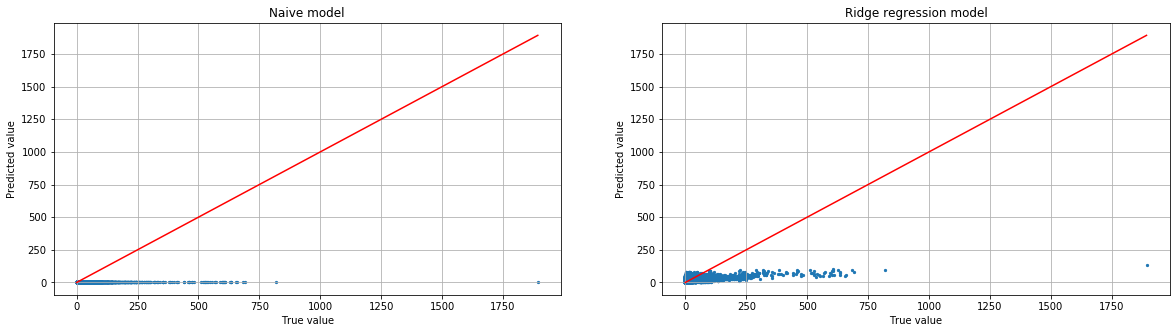

(18765,) (18765,) (18765,)


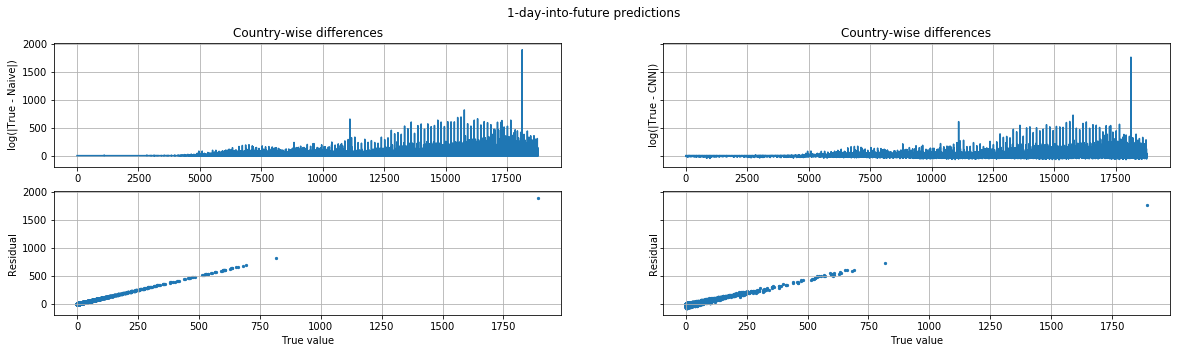

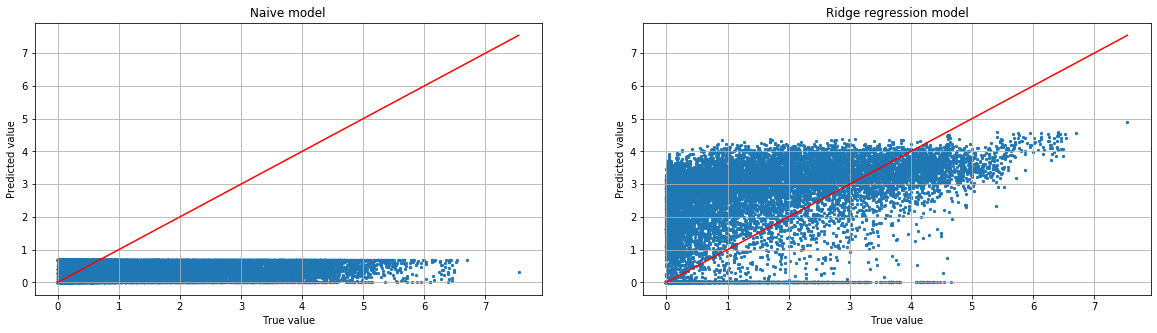

(18765,) (18765,) (18765,)


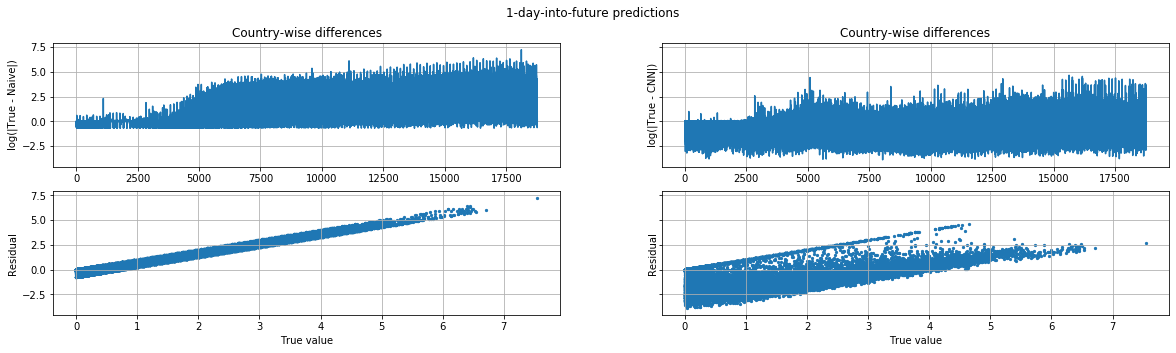

In [69]:
X_train_model = np.concatenate(X_train.reshape(X_train.shape[0], X_train.shape[1], -1), axis=0)
X_test_model = np.concatenate(X_test.reshape(X_test.shape[0], X_test.shape[1], -1), axis=0)
y_train_model = y_train.ravel()
y_test_model = y_test.ravel()


model = Lasso(alpha=0.01, fit_intercept=False, max_iter=5000) 
# model = Ridge(alpha=0.01, fit_intercept=False) 

_ = model.fit(X_train_model, y_train_model.ravel())

if train_or_test == 'train':
    y_true = y_train_model
    y_naive = X_train[:, :, -1, new_cases_index].ravel()
    _, y_predict, mae = classifier_analysis(model, X_train_model, 
                                                 y_train_model.ravel(), 
                                                 plot=False, metric='mae')
else:
    y_true = y_test
    y_naive = X_test[:, :, -1, new_cases_index].ravel()
    _, y_predict, mae = classifier_analysis(model, X_test_model,
                                                 y_test.ravel(),
                                                 plot=False, metric='mae')

print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
y_predict[y_predict<0]=0
print('{}-step MAE [Naive, Ridge Regression] = [{},{}]'.format(
n_days_into_future, mae_train_naive, mae_predict))
print('{}-step R^2 [Naive, Ridge Regression] = [{},{}]'.format(
n_days_into_future, r2_train_naive, r2_predict))

true_predict_plot(y_true.ravel(), y_naive.ravel(), y_predict)
residual_diff_plots(y_true.ravel(), y_naive.ravel(), y_predict , n_days_into_future, data.location.nunique())

true_predict_plot(y_true.ravel(), y_naive.ravel(), y_predict,scale='log')
residual_diff_plots(y_true.ravel(), y_naive.ravel(), y_predict , n_days_into_future, data.location.nunique(),scale='log')

# History minmax

In [73]:
n_prune = 4
first_day = 0

mae_list_naive = []
r2_list_naive = []
mae_list_predict = []
r2_list_predict = []
data = data[data.time_index >= first_day]
model_data = data.iloc[:, n_prune:].copy()#.apply(lambda x : np.log(x+1))
n_features = model_data.shape[-1]
new_cases_index = column_search(model_data,'new_cases_weighted',threshold='match', return_style='iloc')[0]
n_countries = data.location.nunique()
target_data = data.new_cases_weighted
time_index = data.time_index
frame_size = 14
start_date = frame_size + time_index.min()
n_validation_frames = 0
n_test_frames = 1
n_days_into_future = 1
train_or_test = 'train'

for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 2):
    # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
    frame_data = model_data[(time_index < max_date_in_window) & 
                            (time_index >= max_date_in_window-frame_size)]
    #     print(frame_data.shape)
    # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
    reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
    #     print(reshaped_frame_data.shape)
    # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
    # the first axis is always the default iteration axis. 
    # *********************** WARNING: pad_sequences converts to integers by default *********************
    resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
    frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
    if max_date_in_window == start_date:
        X = frame_data_4D.copy()
    else:
        X = np.concatenate((X, frame_data_4D),axis=0)

y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
y_time_index = time_index.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
# y = model_data.new_cases_weighted.values.reshape(-1, model_data.time_index.nunique()).transpose()[-X.shape[0]:,:]

X_train= X[:-n_test_frames,:,:,:]
y_train =  y[:-n_test_frames,:]
X_test = X[-n_test_frames:, :, :, :] 
y_test = y[-n_test_frames:, :]
splits =  (X_train, y_train, X_test, y_test)
y_train_time = y_time_index[:-n_test_frames,:]
y_test_time = y_time_index[-n_test_frames:, :]

if train_or_test=='train':
    y_naive = X_train[:, :, -1, new_cases_index].ravel()
else:
    y_naive = X_test[:, :, -1, new_cases_index].ravel()
    
y_train_model = y_train.ravel()
y_test_model = y_test.ravel()

In [71]:
for i in range(1, X_train.shape[0]+1):
    # find the minima and maxima of all features for all countries, ranging up to current frame and 
    # each time step in the frame. 
    up_to_current_frame_min = X_train[:i,:,:,:].min((0,2))
    up_to_current_frame_max = X_train[:i,:,:,:].max((0,2))
    latest_min_array = np.tile(up_to_current_frame_min[np.newaxis, :, np.newaxis, :],(1,1,frame_size,1))
    latest_max_array = np.tile(up_to_current_frame_max[np.newaxis, :, np.newaxis, :],(1,1,frame_size,1))
    if i == 1:
        frame_wise_min_array = latest_min_array
        frame_wise_max_array = latest_max_array
    else:

        frame_wise_min_array = np.concatenate((frame_wise_min_array, 
                                               latest_min_array)
                                              ,axis=0)
        frame_wise_max_array = np.concatenate((frame_wise_max_array, 
                                               latest_max_array)
                                              ,axis=0)
        
frame_wise_minmax_denominator = (frame_wise_max_array-frame_wise_min_array)
num_zeros_train = (frame_wise_minmax_denominator==0).sum()
print('num zeros train', num_zeros_train)
frame_wise_minmax_denominator[np.where(frame_wise_minmax_denominator==0)]=1
X_train = (X_train - frame_wise_min_array) / frame_wise_minmax_denominator
# Use the latest min and max for test scaling.

frame_wise_denom_for_test = latest_max_array - latest_min_array
num_zeros_test = (frame_wise_denom_for_test==0).sum()

frame_wise_denom_for_test[np.where(frame_wise_denom_for_test==0)] = 1
X_test = (X_test - latest_min_array) / frame_wise_denom_for_test

num zeros train 3712702


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 262836.67864189297, tolerance: 3708.8955827227237
  positive)


There were 2987 negative predictions
1-step MAE [Naive, Ridge Regression] = [3.4279637407069306,3.4695561288954897]
1-step R^2 [Naive, Ridge Regression] = [0.7461509998503622,0.9268186256132275]


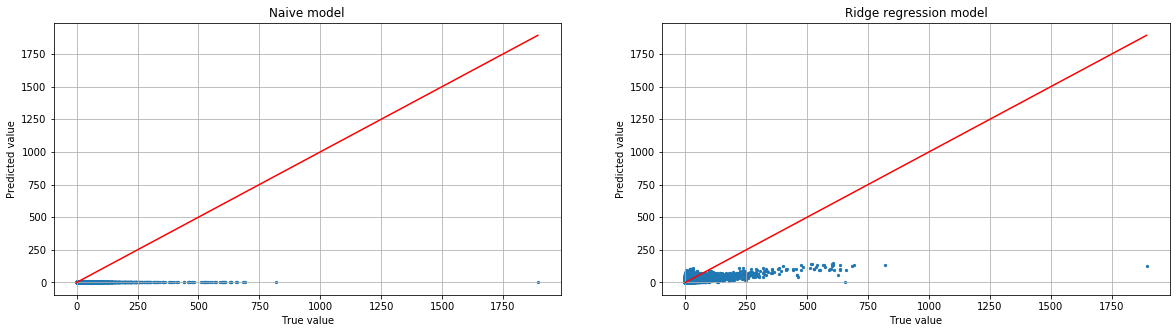

(18765,) (18765,) (18765,)


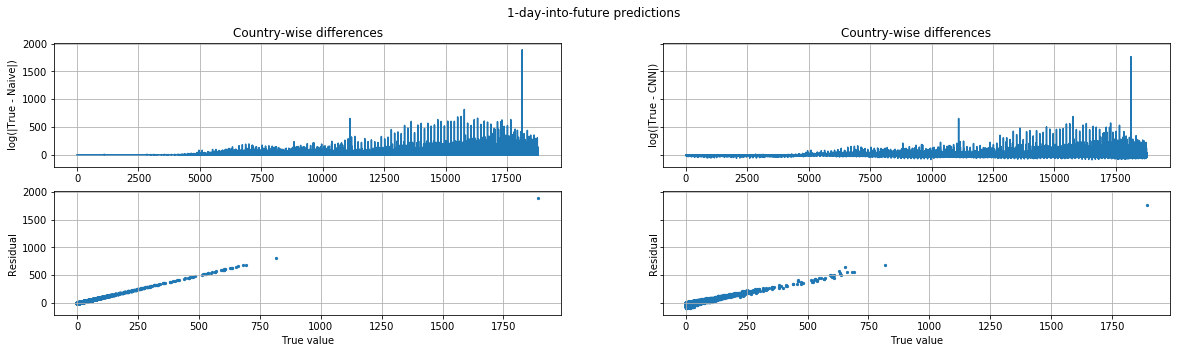

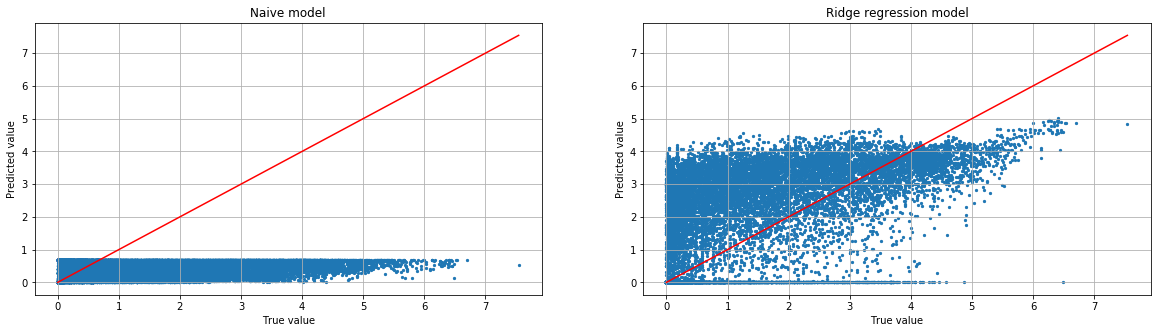

(18765,) (18765,) (18765,)


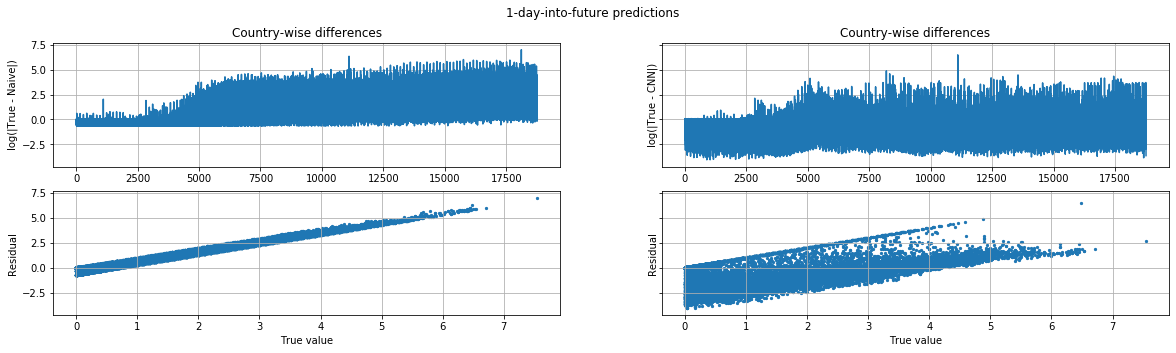

In [72]:
X_train_model = np.concatenate(X_train.reshape(X_train.shape[0], X_train.shape[1], -1), axis=0)
X_test_model = np.concatenate(X_test.reshape(X_test.shape[0], X_test.shape[1], -1), axis=0)

model = Lasso(alpha=0.01, fit_intercept=False, max_iter=5000) 
# model = Ridge(alpha=0.01, fit_intercept=False) 

_ = model.fit(X_train_model, y_train_model.ravel())

if train_or_test == 'train':
     y_true = y_train_model.ravel()
    _, y_predict, mae = classifier_analysis(model, X_train_model, 
                                                 y_train_model.ravel(), 
                                                 plot=False, metric='mae')
else:
    y_true = y_test.ravel()
    _, y_predict, mae = classifier_analysis(model, X_test_model,
                                                 y_test.ravel(),
                                                 plot=False, metric='mae')

print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
y_predict[y_predict<0]=0
print('{}-step MAE [Naive, Ridge Regression] = [{},{}]'.format(
n_days_into_future, mae_train_naive, mae_predict))
print('{}-step R^2 [Naive, Ridge Regression] = [{},{}]'.format(
n_days_into_future, r2_train_naive, r2_predict))

true_predict_plot(y_true.ravel(), y_naive.ravel(), y_predict)
residual_diff_plots(y_true.ravel(), y_naive.ravel(), y_predict , n_days_into_future, data.location.nunique())

true_predict_plot(y_true.ravel(), y_naive.ravel(), y_predict,scale='log')
residual_diff_plots(y_true.ravel(), y_naive.ravel(), y_predict , n_days_into_future, data.location.nunique(),scale='log')

# in-frame mean std

In [ ]:
# for i in range(0, X_train_model.shape[0]):
#     current_frame_mean = X_train_model[i,:,:,:].mean(axis=1)
#     current_frame_std = X_train_model[i,:,:,:].std(axis=1)
#     latest_mean_array = np.tile(current_frame_mean[np.newaxis, :, np.newaxis, :],(1,1,frame_size,1))
#     latest_std_array = np.tile(current_frame_std[np.newaxis, :, np.newaxis, :],(1,1,frame_size,1))
#     if i == 0:
#         frame_only_mean_array = latest_mean_array
#         frame_only_std_array = latest_std_array
#     else:

#         frame_only_mean_array = np.concatenate((frame_only_mean_array, 
#                                                latest_mean_array)
#                                               ,axis=0)
#         frame_only_std_array = np.concatenate((frame_only_std_array, 
#                                                latest_std_array)
#                                               ,axis=0)
        

# frame_only_std_array[np.where(frame_only_std_array==0)]=1
# X_train_model_model = (X_train_model - frame_only_mean_array) / frame_only_std_array
# # Use the latest min and max for test scaling.

# latest_std_array[np.where(latest_std_array==0)] = 1
# X_test_model_model = (X_test_model - latest_mean_array) / latest_std_array

# X_train_model_model = np.concatenate(X_train_model_model.reshape(X_train_model_model.shape[0], 
#                                                                      X_train_model_model.shape[1], -1), axis=0)
# X_test_model_model = np.concatenate(X_test_model_model.reshape(X_test_model_model.shape[0], 
#                                                                    X_test_model_model.shape[1], -1), axis=0)

# y_train_model = y_train.ravel()
# y_test_model = y_test.ravel()

# in-frame minmax

In [ ]:
# for i in range(0, X_train.shape[0]):
#     # find the minima and maxima of all features for all countries, ranging up to current frame and 
#     # each time step in the frame. 
#     current_frame_min = X_train[i,:,:,:].min(axis=1)
#     current_frame_max = X_train[i,:,:,:].max(axis=1)
#     latest_min_array = np.tile(current_frame_min[np.newaxis, :, np.newaxis, :],(1,1,frame_size,1))
#     latest_max_array = np.tile(current_frame_max[np.newaxis, :, np.newaxis, :],(1,1,frame_size,1))
#     if i == 0:
#         frame_only_min_array = latest_min_array
#         frame_only_max_array = latest_max_array
#     else:

#         frame_only_min_array = np.concatenate((frame_only_min_array, 
#                                                latest_min_array)
#                                               ,axis=0)
#         frame_only_max_array = np.concatenate((frame_only_max_array, 
#                                                latest_max_array)
#                                               ,axis=0)
        

# frame_only_minmax_denominator = (frame_only_max_array-frame_only_min_array)
# num_zeros_train = (frame_only_minmax_denominator==0).sum()

# frame_only_minmax_denominator[np.where(frame_only_minmax_denominator==0)]=1
# X_train_normalized = (X_train - frame_only_min_array) / frame_only_minmax_denominator
# # Use the latest min and max for test scaling.

# frame_only_denom_for_test = latest_max_array - latest_min_array
# num_zeros_test = (frame_only_denom_for_test==0).sum()

# frame_only_denom_for_test[np.where(frame_only_denom_for_test==0)] = 1
# X_test_normalized = (X_test - latest_min_array) / frame_only_denom_for_test



In [ ]:
# for i in range(1, X_train.shape[0]+1):
#     # find the minima and maxima of all features for all countries, ranging up to current frame and 
#     # each time step in the frame. 
#     up_to_current_frame_min = X_train[:i,:,:,:].min((0,2))
#     up_to_current_frame_max = X_train[:i,:,:,:].max((0,2))
#     latest_min_array = np.tile(up_to_current_frame_min[np.newaxis, :, np.newaxis, :],(1,1,frame_size,1))
#     latest_max_array = np.tile(up_to_current_frame_max[np.newaxis, :, np.newaxis, :],(1,1,frame_size,1))
#     if i == 1:
#         frame_wise_min_array = latest_min_array
#         frame_wise_max_array = latest_max_array
#     else:

#         frame_wise_min_array = np.concatenate((frame_wise_min_array, 
#                                                latest_min_array)
#                                               ,axis=0)
#         frame_wise_max_array = np.concatenate((frame_wise_max_array, 
#                                                latest_max_array)
#                                               ,axis=0)
        
# frame_wise_minmax_denominator = (frame_wise_max_array-frame_wise_min_array)
# num_zeros_train = (frame_wise_minmax_denominator==0).sum()
# print('num zeros train', num_zeros_train)
# frame_wise_minmax_denominator[np.where(frame_wise_minmax_denominator==0)]=1
# X_train_normalized = (X_train - frame_wise_min_array) / frame_wise_minmax_denominator
# # Use the latest min and max for test scaling.

# frame_wise_denom_for_test = latest_max_array - latest_min_array
# num_zeros_test = (frame_wise_denom_for_test==0).sum()

# frame_wise_denom_for_test[np.where(frame_wise_denom_for_test==0)] = 1
# X_test_normalized = (X_test - latest_min_array) / frame_wise_denom_for_test

In [ ]:
X_train_model = np.concatenate(X_train_normalized.reshape(X_train_normalized.shape[0], 
                                                                     X_train_normalized.shape[1], -1), axis=0)
X_test_model = np.concatenate(X_test_normalized.reshape(X_test_normalized.shape[0], 
                                                                   X_test_normalized.shape[1], -1), axis=0)

y_train_model = y_train.ravel()
y_test_model = y_test.ravel()

# model = Ridge(fit_intercept=False, tol=1e-12) 
model = Ridge(tol=1e-6) 

# model = ElasticNet(positive=True, fit_intercept=False) 

_ = model.fit(X_train_model, y_train_model.ravel())

train_or_test = 'train'
if train_or_test == 'train':
    y_true = y_train_model
    _, y_predict, mae = classifier_analysis(model, X_train_model, 
                                                 y_train_model.ravel(), 
                                                 plot=False, metric='mae')
else:
    y_true = y_test
    _, y_predict, mae = classifier_analysis(model, X_test_model,
                                                 y_test.ravel(),
                                                 plot=False, metric='mae')
    
y_train_naive = X_train[:, :, -1, new_cases_index].ravel()
y_test_naive = X_test[:, :, -1, new_cases_index].ravel()

y_train_naive = X_train[:,:,-1,new_cases_index].ravel()
y_test_naive = X_test[:,:,-1,new_cases_index].ravel()

print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
y_predict[y_predict<0]=0


mae_train_naive = mean_absolute_error(y_true.ravel(), y_train_naive.ravel())
mae_predict = mean_absolute_error(y_true.ravel(), y_predict)
r2_train_naive = explained_variance_score(y_true.ravel(), y_train_naive.ravel())
r2_predict = explained_variance_score(y_true.ravel(), y_predict)

print('{}-step MAE [Naive, Ridge Regression] = [{},{}]'.format(
n_days_into_future, mae_train_naive, mae_predict))
print('{}-step R^2 [Naive, Ridge Regression] = [{},{}]'.format(
n_days_into_future, r2_train_naive, r2_predict))

true_predict_plot(y_true.ravel(), y_train_naive.ravel(), y_predict)
residual_diff_plots(y_true.ravel(), y_train_naive.ravel(), y_predict , n_days_into_future, data.location.nunique())

In [ ]:
data = pd.read_csv('regression_data_optimal.csv', index_col=0)

In [ ]:
plt.plot(X_train_model[:,119,-1,new_cases_index])
plt.plot(y_train_naive[:,119])
plt.plot(y_train[:,119])
plt.plot(y_train_model[:,119])

# history minmax

In [ ]:
y_test_model[np.where(y_test_model<0)] = 0 
y_train_model[np.where(y_train_model<0)] = 0 

for i in range(1, X_train_model.shape[0]+1):
    # find the minima and maxima of all features for all countries, ranging up to current frame and 
    # each time step in the frame. 
    up_to_current_frame_min = X_train_model[:i,:,:,:].min((0,2))
    up_to_current_frame_max = X_train_model[:i,:,:,:].max((0,2))
    latest_min_array = np.tile(up_to_current_frame_min[np.newaxis, :, np.newaxis, :],(1,1,frame_size,1))
    latest_max_array = np.tile(up_to_current_frame_max[np.newaxis, :, np.newaxis, :],(1,1,frame_size,1))
    if i == 1:
        frame_min_array = latest_min_array
        frame_max_array = latest_max_array
    else:

        frame_min_array = np.concatenate((frame_min_array, 
                                               latest_min_array)
                                              ,axis=0)
        frame_max_array = np.concatenate((frame_max_array, 
                                               latest_max_array)
                                              ,axis=0)
        
frame_minmax_denominator = (frame_max_array-frame_min_array)
num_zeros_train = (frame_minmax_denominator==0).sum()

frame_minmax_denominator[np.where(frame_minmax_denominator==0)]=1
X_train_model = (X_train_model - frame_min_array) / frame_minmax_denominator
# Use the latest min and max for test scaling.

frame_denom_for_test = latest_max_array - latest_min_array
num_zeros_test = (frame_denom_for_test==0).sum()

frame_denom_for_test[np.where(frame_denom_for_test==0)] = 1
X_test_model = (X_test_model - latest_min_array) / frame_denom_for_test
X_train_model_copy = X_train_model.copy()


In [ ]:
y_train_model = (y_train - frame_min_array[:, :, -1, new_cases_index]) / frame_minmax_denominator[:,:,-1,new_cases_index]
y_test_model= (y_test - latest_min_array[:, :, -1, new_cases_index]) / frame_denom_for_test[:,:,-1,new_cases_index]

# y-scaling

In [ ]:
y_train_naive = X_train[:, :, -1, new_cases_index].ravel()
y_test_naive = X_test[:, :, -1, new_cases_index].ravel()
y_train = y_train_model
y_test = y_test_model

y_train_model = ((y_train_model - frame_min_array[:, :, -1, new_cases_index]) 
                       / frame_minmax_denominator[:,:,-1,new_cases_index])
y_test_model = ((y_test_model - latest_min_array[:, :, -1, new_cases_index]) 
                      / frame_denom_for_test[:,:,-1,new_cases_index])

y_test_model[np.where(y_test_model<0)] = 0 
y_train_model[np.where(y_train_model<0)] = 0 

In [ ]:

X_train = np.concatenate(X_train_model.reshape(X_train_model.shape[0], 
                                                                     X_train_model.shape[1], -1), axis=0)
X_test = np.concatenate(X_test_model.reshape(X_test_model.shape[0], 
                                                                   X_test_model.shape[1], -1), axis=0)

model = Ridge(tol=1e-6) 

# model = ElasticNet(positive=True, fit_intercept=False) 

_ = model.fit(X_train, y_train.ravel())

train_or_test = 'train'
if train_or_test == 'train':
    y_true = y_train
    _, y_predict, mae = classifier_analysis(model, X_train, 
                                                 y_train.ravel(), 
                                                 plot=False, metric='mae')
else:
    y_true = y_test
    _, y_predict, mae = classifier_analysis(model, X_test,
                                                 y_test.ravel(),
                                                 plot=False, metric='mae')
    


print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
y_predict[y_predict<0]=0


mae_train_naive = mean_absolute_error(y_true.ravel(), y_train_naive.ravel())
mae_predict = mean_absolute_error(y_true.ravel(), y_predict)
r2_train_naive = explained_variance_score(y_true.ravel(), y_train_naive.ravel())
r2_predict = explained_variance_score(y_true.ravel(), y_predict)

print('{}-step MAE [Naive, Ridge Regression] = [{},{}]'.format(
n_days_into_future, mae_train_naive, mae_predict))
print('{}-step R^2 [Naive, Ridge Regression] = [{},{}]'.format(
n_days_into_future, r2_train_naive, r2_predict))

true_predict_plot(y_true.ravel(), y_train_naive.ravel(), y_predict)
residual_diff_plots(y_true.ravel(), y_train_naive.ravel(), y_predict , n_days_into_future, data.location.nunique())

First two column of X_train is the minimum of the time index and days_since_first_case of each frame, meaning that they will have been normalized to 0, always. Drop these columns as they are literally just 0's.

In [ ]:
X_train_normalized_model[:,0].sum()

when collapsing the last axis with reshape, the format I had in mind the columns would be grouped by time but instead I think they're grouped by feature. If grouped by feature then the first 14 rows should be 

zeroth column is time index.

If concatenate is doing what I think it is, it should be sorted by time_index then country. i.e. the -n_country row is the last row of the first country, with time_steps and features contracted. this is indeed what is happening, so in the final 2d array,
the first n_countries rows corresponds to the first frame, and the columns are the features at the different time steps (a total of time steps equals ```frame_size```). s.t. X_train looks like the following

    n_countries @ frame=frame_size, frame [n_features(t=0),n_features(t=1),...,n_features(t=frame_size)]
    n_countries @ frame=frame_size+1, frame [n_features(t=1),n_features(t=2),...,n_features(t=frame_size+1)]
    n_countries @ frame=frame_size+1, frame [n_features(t=1),n_features(t=2),...,n_features(t=frame_size+1)]
    n_countries @ frame=present_date-n_days_into_future- n_test_frames  [n_features(t=1),n_features(t=2),...,n_features(t=frame_size+1)]
    
The normalization only occurs with respect to the dates inside the frame, i.e. each *row* of the final array.

In [ ]:
y_train_model = (y_train- frame_wise_min_array[:, :, -1, 2]) / frame_wise_minmax_denominator[:,:,-1,2]
y_test_model= (y_test - latest_min_array[:, :, -1, 2]) / frame_wise_denom_for_test[:,:,-1,2]

In [ ]:
# (X_train, y_train, X_test, y_test) = splits

# y_train_naive_time_index =  X_train[:, :, -1, 0]
# y_train_naive = X_train[:, :, -1, new_cases_index]

# y_test_naive_time_index =  X_test[:, :, -1, 0]
# y_test_naive = X_test[:, :, -1, new_cases_index]

# y_train_naive = X_train[:, :, -1, new_cases_index]
# y_test_naive = X_test[:, :, -1, new_cases_index]

In order to normalize in a consistent manner, need to find the min and max for each country and each feature up until that point in time. 

In [ ]:
# tile_shape = np.array(np.array(X.shape) / np.array(X_min.shape), dtype=int)
# denominator = np.tile(X_max, tile_shape) - np.tile(X_min, tile_shape)
# denominator[denominator==0] = 1
# X_scaled = (X - np.tile(X_min, tile_shape)) / denominator

This takes the minima of each feature of each country up to current frame's end date. Need copies for each day in frame, but
only one frame value i.e.

In [ ]:
# y_true.new_cases_weighted.values.ravel(), y_train_naive.new_cases_weighted.values.ravel(), y_predict = ys

print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
y_predict[y_predict<0]=0


mae_train_naive = mean_absolute_error(y_true.new_cases_weighted.values.ravel(), y_train_naive.new_cases_weighted.values.ravel())
mae_predict = mean_absolute_error(y_true.new_cases_weighted.values.ravel(), y_predict)
r2_train_naive = explained_variance_score(y_true.new_cases_weighted.values.ravel(), y_train_naive.new_cases_weighted.values.ravel())
r2_predict = explained_variance_score(y_true.new_cases_weighted.values.ravel(), y_predict)

print('{}-step MAE [Naive, Ridge Regression] = [{},{}]'.format(
n_days_into_future, mae_train_naive, mae_predict))
print('{}-step R^2 [Naive, Ridge Regression] = [{},{}]'.format(
n_days_into_future, r2_train_naive, r2_predict))

true_predict_plot(y_true.new_cases_weighted.values.ravel(), y_train_naive.new_cases_weighted.values.ravel(), y_predict)
residual_diff_plots(y_true.new_cases_weighted.values.ravel(), y_train_naive.new_cases_weighted.values.ravel(), y_predict , n_days_into_future, data.location.nunique())

X time index goes from 0 to max-n_days_into_future. 

first slice of X goes from 0:n_days_into_future (non-inclusive), i.e. 13. Therefore, the first prediction being made
is t=27. Therefore, the first row of y_train equals X[27,:,0,2]

X slices. start at 0, end at n_days_into_future - 1.

so X[14] corresponds to n_days_into_future - 1 + 14 = 27

X's rows correspond to the minimum time_index (starting from 0) value. so X[13] is 13,14,....26. 

In [ ]:
(X_train, y_train, X_test, y_test) = splits

y_train_naive = X_train[:,:,-1,2]
y_test_naive = X_test[:,:,-1,2]

In [ ]:
X_train = np.concatenate(X_train.reshape(X_train.shape[0], X_train.shape[1], -1), axis=0)
X_test = np.concatenate(X_test.reshape(X_test.shape[0], X_test.shape[1], -1), axis=0)
y_train = y_train.ravel()
y_test = y_test.ravel()

In [ ]:
y_train_naive[14,26]

In [ ]:
y_train.reshape(-1, n_countries)[0,26]

question for mike, each of the shifted variables is being treated as feature, should they be normalized separately...? or normalized before the shift.

need the naive values, which are the values n_days_into_future before y_train rows. To see that this is true, look at
time_index + n_days_into_future rows. of X. i.e. first row of y is time==n_days_into_future for X.

y_train[t,c] = X[t+n_days_into_future, c, 0, 2] OR 

y_train[t,c] = X[t+1, c, -1, 2]

y_train[0, 26] = X[14,26,-1,2] = X[27,26,0,2]

I think minmaxing each frame might actually be really dumb.

# old way of modeling, single day single prediction

In [ ]:
train_or_test = 'train'
n_test_days = 1
n_days_into_future = 14
n_prune = 4
# X has already been shifted by n_days_into future, so the last day in X is predicting that last day + n_days_into_future. 
#     y_naive = X.new_cases_weighted[X.time_index > X.time_index.max() - n_days_into_future]
n_countries = data.location.nunique()
model_data = full_data
# model_data = data.drop(columns=column_search(data, 'test'))

chronological_data = model_data.sort_values(by=['time_index','location'])

X = chronological_data[(chronological_data.time_index 
                        <=  chronological_data.time_index.max() - n_days_into_future)].reset_index(drop=True)

y = chronological_data[(chronological_data.time_index  
                        >= n_days_into_future)].loc[:, ['time_index','new_cases_weighted']].reset_index(drop=True)

# X = X[(X.days_since_first_case > 0) & (X.time_index > 40)]
# X = X[(X.days_since_first_case > 0)]
# X = X[X.time_index > 40]

y = y.loc[X.index,:]
train_indices = X[X.time_index <= X.time_index.max() - n_test_days].index
test_indices = X[X.time_index > X.time_index.max() - n_test_days].index

In [ ]:
pd.DataFrame(data[data.time_index.isin(list(range(7)))].values.reshape(-1, 7*24))

data.set_index('time_index')#.transpose()#[list(range(7))]#.transpose()

chronological_data.set_index('time_index').transpose()[list(range(7))].transpose()

chronological_data.set_index('time_index').transpose()

In [ ]:
# 2 slices date, location, 4 slices date,location,time_index, days_since_first_case

X_train = X.loc[train_indices, :]#.apply(lambda x : np.log(x+1))
y_train = y.loc[train_indices,['time_index','new_cases_weighted']]

X_test = X.loc[test_indices,:]#.apply(lambda x : np.log(x+1))
y_test =  y.loc[test_indices,['time_index','new_cases_weighted']]#.values.ravel()

# if train_or_test == 'train':
y_train_naive = X_train.loc[:, ['time_index','new_cases_weighted']]
# else:
y_test_naive = X_test.loc[:, ['time_index','new_cases_weighted']]
X_train = X_train.iloc[:,n_prune:]
X_test = X_test.iloc[:,n_prune:]
col_transformer = MinMaxScaler()
_ = col_transformer.fit(X_train)
X_train_normalized =  col_transformer.transform(X_train)
X_test_normalized =  col_transformer.transform(X_test)

To compute new rolling means, take new drift feature values, concatenate with those in training, and then roll.
Need to reintroduce indexes however to sort the values correctly. 

baseline_time_series

# COVID-19 Case number modeling with no new features.
<a id='model'></a>
[Return to table of contents](#toc)

The first segment of the modeling process takes the "original" data, reformatted as per the
data cleaning notebook and then performs the necessary operations to encode the categorical variables.
The target variable is assigned to be the number of cases and the pipeline for the modeling process is as
follows (current iteration):
    
    1. Encode data, split into feature and target data.
    2. Create cross validation folds; split into train-test and holdout data sets. 
    2. Normalize the feature data via sklearn's StandardScaler. 
    3. Perform PCA on the normalized feature data
    4. Apply Ridge regression on the normalized, PCA transformed data. 

# Single step predictions

Need location for groupby indices, but date and date proxy I do not think are useful currently. 

Create cross validation folds which respect the time-series dates.

Instead of flailing about let's actually type out how to do this.

Steps that need to be completed.

    Target variable shifting.
    CV folds
    Feature encoding
    

Get the indices which correspond to each country, prior to shifting the target variable time series.
Assign target and feature variable arrays prior to shifting the target variable.
I don't think dropping the case data is actually necessary so long as the time series aspect is respected.
Get the data ready for training

Collect the indices which correspond to each country.

Shift the target variable by one so that the feature data up until day n-1 is predicting the target variable at day n.
In other words, train on data which is up to but not including the date of prediction. 

What Mike said:

X_train ......................................... y_train

DATA UP TO AND INCLUDING 2020-05-01 ............. TARGET ON 2020-05-02

This does not predict the first day and does not include the data on the last day. 
Therefore the correct operation is to group by country, shift the target by -1 and drop the last day of data (drop NaN).

Shift the target data so that its suited to prediction.

Slice and rename variables X,y 

Each countries' indices except minus the last day. 

Create CV folds....unused other than train/test split.

I split the data in 7 folds, but use the first 6 as a training and the 7th as a testing set.

Cast bool features as int, one-hot encode the categorical (object) features.

Assign target variable and remove the corresponding variables from the regressors

Split between traintest (Cross validation, currently used simply as a 1-fold training set)
and holdout (final testing).

Fit the StandardScaler() transformer instance with the training data, only applied to the continuous, time dependent
numerical features 

<!-- For every date, need a prediction. For every date need to scale/do pca.
therefore everything is a for looop around the date.  -->

Generate predictors from drift, naive strategies. 

# 7 day step predictions


day 1 to predict day 8
day 1-2 to predict day 9
days 1-3 to predict day 10 ----> shift -7

Create the target variable, the change in the amount of daily new cases (today new cases per million - yesterday new cases per million). Store the "present values" as a predictor, but then shift the values by a week, to get the target variable. Due to the usage of first order finite difference to calculate the change, it is not defined for the first day of the time series, and the target variables are not defined for dates within 7 days, as their 7 day futures do not exist yet. 

Is it better to predict the smoothed quantity, or use the smoothed quantity to predict the jagged quantity. 

In [ ]:
fold_size = 7
folds = [X.date.unique()[fold_size*i:fold_size*(i+1)] for i in range(1 + len(X.date.unique())//fold_size)]
folds_indices = [X[X.date.isin(fold)].index for fold in folds]
folds_series = pd.Series(folds_indices).to_frame(name='folds')

fold_indices = folds_series.values.flatten()[:-2]
test_indices = folds_series.values.flatten()[-2:]
test_indices = test_indices[0].append(test_indices[1]).sort_values()

train_indices = fold_indices[0]
for indices in fold_indices[1:]:
    train_indices = full_index.union(indices)

for i, epochs in enumerate(folds_series.values.flatten()):
    start, end = model_data.loc[epochs, 'date'].min(), model_data.loc[epochs, 'date'].max()
    print('Epoch {} spans the dates {} to {}'.format(i,start,end))

In [ ]:
start, end = model_data.loc[train_indices, 'date'].min(), model_data.loc[train_indices, 'date'].max()
print('Training data spans the dates {} to {}'.format(start,end))

In [ ]:
start, end = model_data.loc[test_indices, 'date'].min(), model_data.loc[test_indices, 'date'].max()
print('Testing data spans the dates {} to {}'.format(start, end))

The date of predictions range from (initial date) + 7  to (final date) + 7. 

Clearly biased as true value increases. 

Warning raised because the first prediction uses only 1 day's data.

Likewise, fit the PCA() transformer instance with the training data then apply it
to both the training and holdout sets.

Finally, fit Ridge regression model to the training data, and test it with the holdout set.

I think I'm messing up how to actually train test split; mike seems to indicate that for every prediction, the model is trained
on all but one day. 

These results vastly exceeded my expectations (with respect to the explained variance score). 
**I am making a large mistake of including the variables from the future like deaths, active, recovered, etc. This model is not predicting the future.**

The predicted vs. the actual
value has two key patterns which stand out; namely, the underestimation of very large values and the overestimation of intermediate values (from one-hundred and fifth to two-hundred thousand). I think this is due to the nature of the case number time series. Looking to a one dimensional sigmoid curve as a crude example. This function is motivated by simple epidemiological models as a crude approximation for expected behavior. My model seems to imply that the larger values indicate that the spread of COVID is past the inflection point present in the sigmoid function.

Therefore, the Ridge regression predictions sort of make sense as the asymptotic behavior of the sigmoid curve
has not yet begun.

# COVID-19 Case number modeling with new features.
<a id='modelplus'></a>
[Return to table of contents](#toc)

Repeat the modeling steps above, applied to the dataset which calculated many different moving averages. 

Next, I look at the effect of the number of PCA components

Looking at the plot of explained variance versus number of PCA components I believe it is fairly obvious that
there is something wrong. I believe it's because I'm using different facets of the case number (deaths, active cases, number recovered) in the prediction.

Plot of explained variance score as a function of the features included; to see which features have the most effect.

This is not doing what I want. This is saying given I know the number of deaths/active cases/number recovered I can infer how many confirmed cases there were. This is not the same as predicting future numbers of cases. i.e. this is not plugging in a date (or days since first infection) and getting a number out.... 